# 关于 Stim 的基本了解


In [1]:
import stim
import numpy as np

以上是相关的包，都可以用 pip 安装

通过 `stim.Circuit()` 创建一个电路实例，然后使用 `circuit.append(name_of_gate, list_of_targets)` 来添加量子门。

量子门索引在 [Stim gates reference](https://github.com/quantumlib/Stim/blob/main/doc/gates.md) 查询。_target_ 通常指一个 qubit 的编号。

以下电路用于制备一个 Bell 对并测量：

In [2]:
circuit = stim.Circuit()
# First, the circuit will initialize a Bell pair.
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
circuit.append("M", [0, 1])

print(repr(circuit))

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
''')


使用 `repr(circuit)` 得到该电路的文件语法，通过该文本创建的电路和上面我们通过 `append` 方法创建的是一致的。

接下来通过 `circuit.diagram()` 可以生成示意图。注意每次测量后面都跟随 _M:rec[index]_，这是表示测量记录编号，记录也是一个重要概念。

`circuit.diagram('timeline-svg')` 可以生成矢量图。

In [3]:
circuit.diagram()

q0: -H-@-M:rec[0]-
       |
q1: ---X-M:rec[1]-

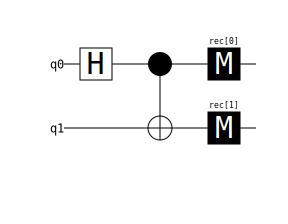

In [4]:
circuit.diagram('timeline-svg')

接下来使用 `compile_sampler` 编译该电路，然后使用 `sample` 做采样。

由于纠缠，两个 qubit 的测量结果一致，并且各有 50% 概率为 0 或者 1。

In [5]:
sampler = circuit.compile_sampler()
print(sampler.sample(shots=10))

[[ True  True]
 [ True  True]
 [False False]
 [False False]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]
 [ True  True]
 [False False]]


# 重复码与检测子

## 在电路中增加检测子
检测子将测量结果做异或进行所谓奇偶校验。

使用 `circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)])` 创建一个检测子。`stim.target_rec(-1)` 表示最新的一条测量记录，在上面的 Bell 态制备电路中，其就为 `rec[1]`，`stim.target_rec(-2)` 表示次新的测量记录 `rec[0]`。

In [6]:
# Indicate the two previous measurements are supposed to consistently agree.
circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)])
print(repr(circuit))

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
''')


可以为检测子指定坐标，其对采样模拟没有影响，但可以方便绘图。如 `circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)]，(0, 1))`

进行测量采样，使用 `compile_detector_sampler` 编译：

In [7]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=5))

[[False]
 [False]
 [False]
 [False]
 [False]]


五次结果均为 False，说明没有发生检测事件，测量结果总保持相同的奇偶性。

接下来尝试增加错误，错误有 _qubit depolarization(DEPOLARIZE1)_, _phase damping(Z\_ERROR)_, _bit flip(X\_ERROR)_ 等等，这里可以用 X_ERROR 示例。既可以用 `circuit.append("X_ERROR", [0], 0.1)` 直接给 qubit0 添加 10% 概率发生的 bit flip，也可以直接编写文法。

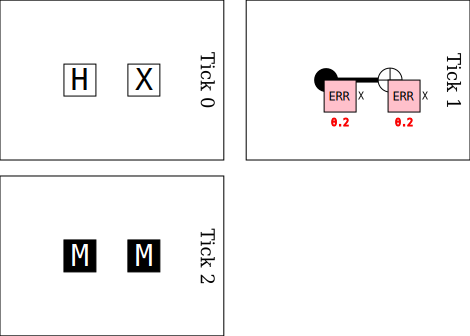

In [8]:
circuit = stim.Circuit('''
    H 0
    X 1
    TICK

    CX 0 1
    X_ERROR(0.2) 0 1
    TICK
                       
    M 0 1
    DETECTOR rec[-1] rec[-2]
''')

circuit.diagram('timeslice-svg')

使用 `TICK` 对电路模拟没有影响，它用于声明在同一帧中发生的事件或门操作，方便使用 `circuit.diagram('timeslice-svg')` 进行可视化。

尝试编译并采样：

In [9]:
sampler = circuit.compile_sampler(seed=100)
print(sampler.sample(shots=10))

sampler = circuit.compile_detector_sampler(seed=100)
print(sampler.sample(shots=10))

[[ True False]
 [False  True]
 [ True  True]
 [False False]
 [False False]
 [ True  True]
 [ True  True]
 [False  True]
 [ True False]
 [ True False]]
[[False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]]


通过设定种子可以看到测量结果和检测子计算结果的对应关系，即发生异常校验结果时，检测子会返回 True。

## 重复码

以下是一个码距为 7，即把 $\vert 0_L \rangle$ 编码为 $\vert 0000000 \rangle$ 的重复码。其中 qubit 0, 2, 4... 是数据比特，qubit 1, 3, 5... 是辅助比特。`R` 即 reset 操作，将该比特设置为 $\vert 0 \rangle$。`MR` 即 measure&reset，测量后将该比特重置为 $\vert 0 \rangle$。注意重复码的检测子使用 当前测量结果和上一轮测量结果做校验。

stim.Circuit('''
    R 0 1 2 3 4 5 6 7 8 9 10 11 12
    TICK
    DEPOLARIZE1(0.04) 0 2 4 6 8 10 12
    CX 0 1 2 3 4 5 6 7 8 9 10 11
    TICK
    CX 2 1 4 3 6 5 8 7 10 9 12 11
    TICK
    X_ERROR(0.01) 1 3 5 7 9 11
    MR 1 3 5 7 9 11
    DETECTOR(1, 0) rec[-6]
    DETECTOR(3, 0) rec[-5]
    DETECTOR(5, 0) rec[-4]
    DETECTOR(7, 0) rec[-3]
    DETECTOR(9, 0) rec[-2]
    DETECTOR(11, 0) rec[-1]
    REPEAT 9 {
        TICK
        DEPOLARIZE1(0.04) 0 2 4 6 8 10 12
        CX 0 1 2 3 4 5 6 7 8 9 10 11
        TICK
        CX 2 1 4 3 6 5 8 7 10 9 12 11
        TICK
        X_ERROR(0.01) 1 3 5 7 9 11
        MR 1 3 5 7 9 11
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-6] rec[-12]
        DETECTOR(3, 0) rec[-5] rec[-11]
        DETECTOR(5, 0) rec[-4] rec[-10]
        DETECTOR(7, 0) rec[-3] rec[-9]
        DETECTOR(9, 0) rec[-2] rec[-8]
        DETECTOR(11, 0) rec[-1] rec[-7]
    }
    X_ERROR(0.01) 0 2 4 6 8 10 12
    M 0 2 4 6 8 10 12
    DETECTOR(1, 1) rec[-6] rec[-7] rec[-13]
 

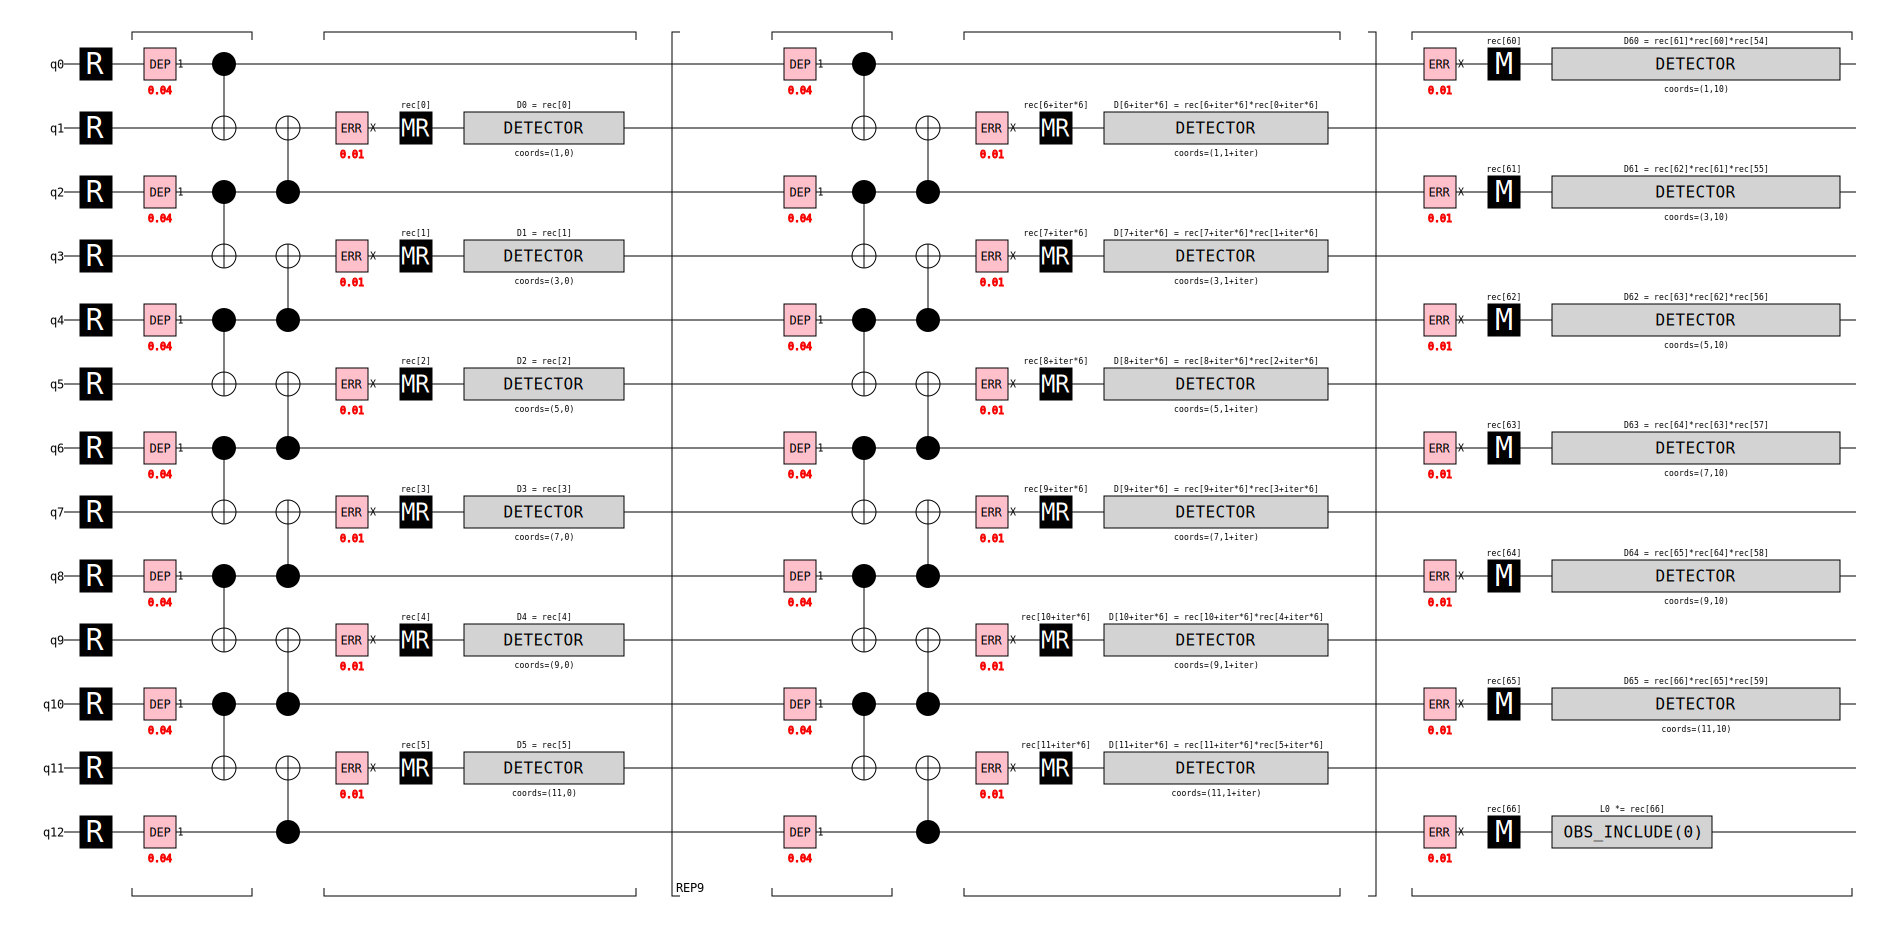

In [10]:
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=10,
    distance=7,
    before_round_data_depolarization=0.04,
    before_measure_flip_probability=0.01
)

print(repr(circuit))
circuit.diagram('timeline-svg')


可以通过以下两段代码对比更直接地看到测量结果与检测子校验结果。

In [11]:
measure_num = 6
import random
seed = random.randint(0, 2**32 - 1)

sampler = circuit.compile_sampler(seed=seed)
one_sample = sampler.sample(shots=1)[0]
for k in range(0, len(one_sample), measure_num):
    timeslice = one_sample[k:k+measure_num]
    print("".join("1" if e else "_" for e in timeslice))

1_____
______
______
______
______
______
11____
11____
11____
11____
_1____
_


In [12]:
detector_sampler = circuit.compile_detector_sampler(seed=seed)
one_sample = detector_sampler.sample(shots=1)[0]
for k in range(0, len(one_sample), measure_num):
    timeslice = one_sample[k:k+measure_num]
    print("".join("!" if e else "_" for e in timeslice))


!_____
!_____
______
______
______
______
!!____
______
______
______
______


# PyMatching 检错与评估物理错误率阈值

## PyMatching 使用

我们使用 `circuit.detector_error_model()` 来将电路中的检测子和错误提取出来。

stim.DetectorErrorModel('''
    error(0.0266667) D0
    error(0.0266667) D0 D1
    error(0.01) D0 D6
    error(0.0266667) D1 D2
    error(0.01) D1 D7
    error(0.0266667) D2 D3
    error(0.01) D2 D8
    error(0.0266667) D3 D4
    error(0.01) D3 D9
    error(0.0266667) D4 D5
    error(0.01) D4 D10
    error(0.01) D5 D11
    error(0.0266667) D5 L0
    detector(1, 0) D0
    detector(3, 0) D1
    detector(5, 0) D2
    detector(7, 0) D3
    detector(9, 0) D4
    detector(11, 0) D5
    repeat 8 {
        error(0.0266667) D6
        error(0.0266667) D6 D7
        error(0.01) D6 D12
        error(0.0266667) D7 D8
        error(0.01) D7 D13
        error(0.0266667) D8 D9
        error(0.01) D8 D14
        error(0.0266667) D9 D10
        error(0.01) D9 D15
        error(0.0266667) D10 D11
        error(0.01) D10 D16
        error(0.01) D11 D17
        error(0.0266667) D11 L0
        shift_detectors(0, 1) 0
        detector(1, 0) D6
        detector(3, 0) D7
        detector(5, 0) D8
        dete

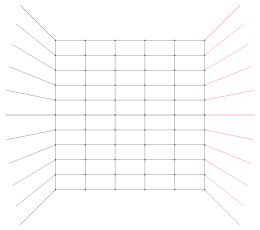

In [13]:
dem = circuit.detector_error_model()
print(repr(dem))
dem.diagram("matchgraph-svg")

上图中将原电路做了 90° 旋转，其中每个节点代表一个检测子(detector)，每条边代表一个错误机制(error mechanism)，边权重与错误概率关联，由此就可以转换成图问题，方便使用 `pymatching` 做解码。

In [14]:
import pymatching

- 首先将电路编译并采样。`sample()` 方法中设置了 `separate_observables=True`，其会额外返回一个观测量记录，对应电路图中 `OBSERVABLE_INCLUDE` 的部分。`OBSERVABLE_INCLUDE(0) rec[-1]` 表示将最近的一条测量记录纳入到观测量 0 中，最终将所有被纳入的记录做异或求值。其用于在检测电路中保留测量结果而不只余下检测子的计算结果。此处表征的是 qubit 12 的最后一次测量结果。
- 构建解码器。
- 运行解码器得到预测结果。
- 比较预测结果和实际结果，不相同则认为发生了逻辑错误。


In [15]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # 1. Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # 2. Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # 3. Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # 4. Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [16]:
circuit = stim.Circuit.generated("repetition_code:memory", rounds=100, distance=9, before_round_data_depolarization=0.03)
num_shots = 100000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 5 wrong predictions (logical errors) out of 100000 shots


**关于错误：** 错误可以构成串联错误（即涉及多个相邻 qubit），被称为 _error chains_。经典 MWPM 算法可以对于稀疏错误实现错误检测，但是当错误密度增加和错误链长度增加时开始失效。

## Monte Carlo 采样 评估物理错误率阈值
多次采样，考察在不同码距下，逻辑错误率与物理错误率的关系。曲线交汇点即为物理错误率阈值处，此时增加码距并不会显著降低逻辑错误率。

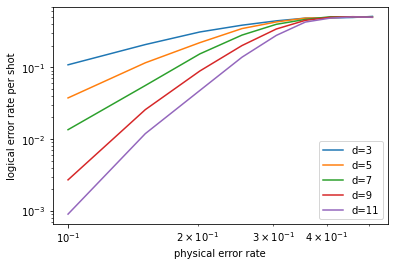

In [17]:
import matplotlib.pyplot as plt

num_shots = 10_000
for d in [3, 5, 7, 9, 11]:
    xs = []
    ys = []
    for noise in np.linspace(0.1, 0.51, 9):
        circuit = stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise)
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()

使用 `sinter` 包来做 Monte Carlo 采样

In [18]:
import sinter
from typing import List

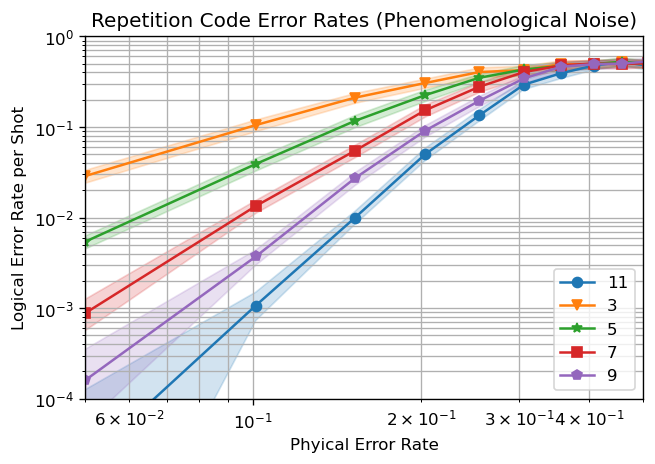

In [19]:
tasks = [
    sinter.Task(
        circuit=stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3, 5, 7, 9, 11]
    for noise in np.linspace(0.05, 0.51, 10)
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000,
    max_errors=500,
)

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_ylim(1e-4, 1e-0)
ax.set_xlim(5e-2, 5e-1)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Phenomenological Noise)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

# 关于表面码的相关代码研究

表面码的原理部分可以先搁置，先做代码实现，反正有现成代码可用。

以下生成表面码并做相应的图展示。

In [50]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_x",
    rounds=1,
    distance=7,
    after_clifford_depolarization=0.001,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001)

error_model = surface_code_circuit.detector_error_model(decompose_errors=True)
print(error_model)


error(0.001931182734310662227) D0 D4
error(0.003590083941683587868) D0 D24
error(0.001931182734310662227) D0 L0
error(0.002727880294778892503) D1 D4
error(0.001931182734310662227) D1 D5
error(0.0002667378157289137966) D1 D24
error(0.003854906535114725925) D1 D25
error(0.0005333333333331478519) D1 D28
error(0.005176901863013953081) D1 L0
error(0.0002667378157289137966) D1 L0 ^ D24 L0
error(0.002727880294778892503) D2 D5
error(0.001931182734310662227) D2 D6
error(0.0002667378157289137966) D2 D25
error(0.003854906535114725925) D2 D26
error(0.0005333333333331478519) D2 D29
error(0.005176901863013953081) D2 L0
error(0.0002667378157289137966) D2 L0 ^ D25 L0
error(0.002727880294778892503) D3 D6
error(0.001931182734310662227) D3 D7
error(0.0002667378157289137966) D3 D26
error(0.003854906535114725925) D3 D27
error(0.0005333333333331478519) D3 D30
error(0.005176901863013953081) D3 L0
error(0.0002667378157289137966) D3 L0 ^ D26 L0
error(0.001931182734310662227) D4 D8
error(0.001931182734310662227

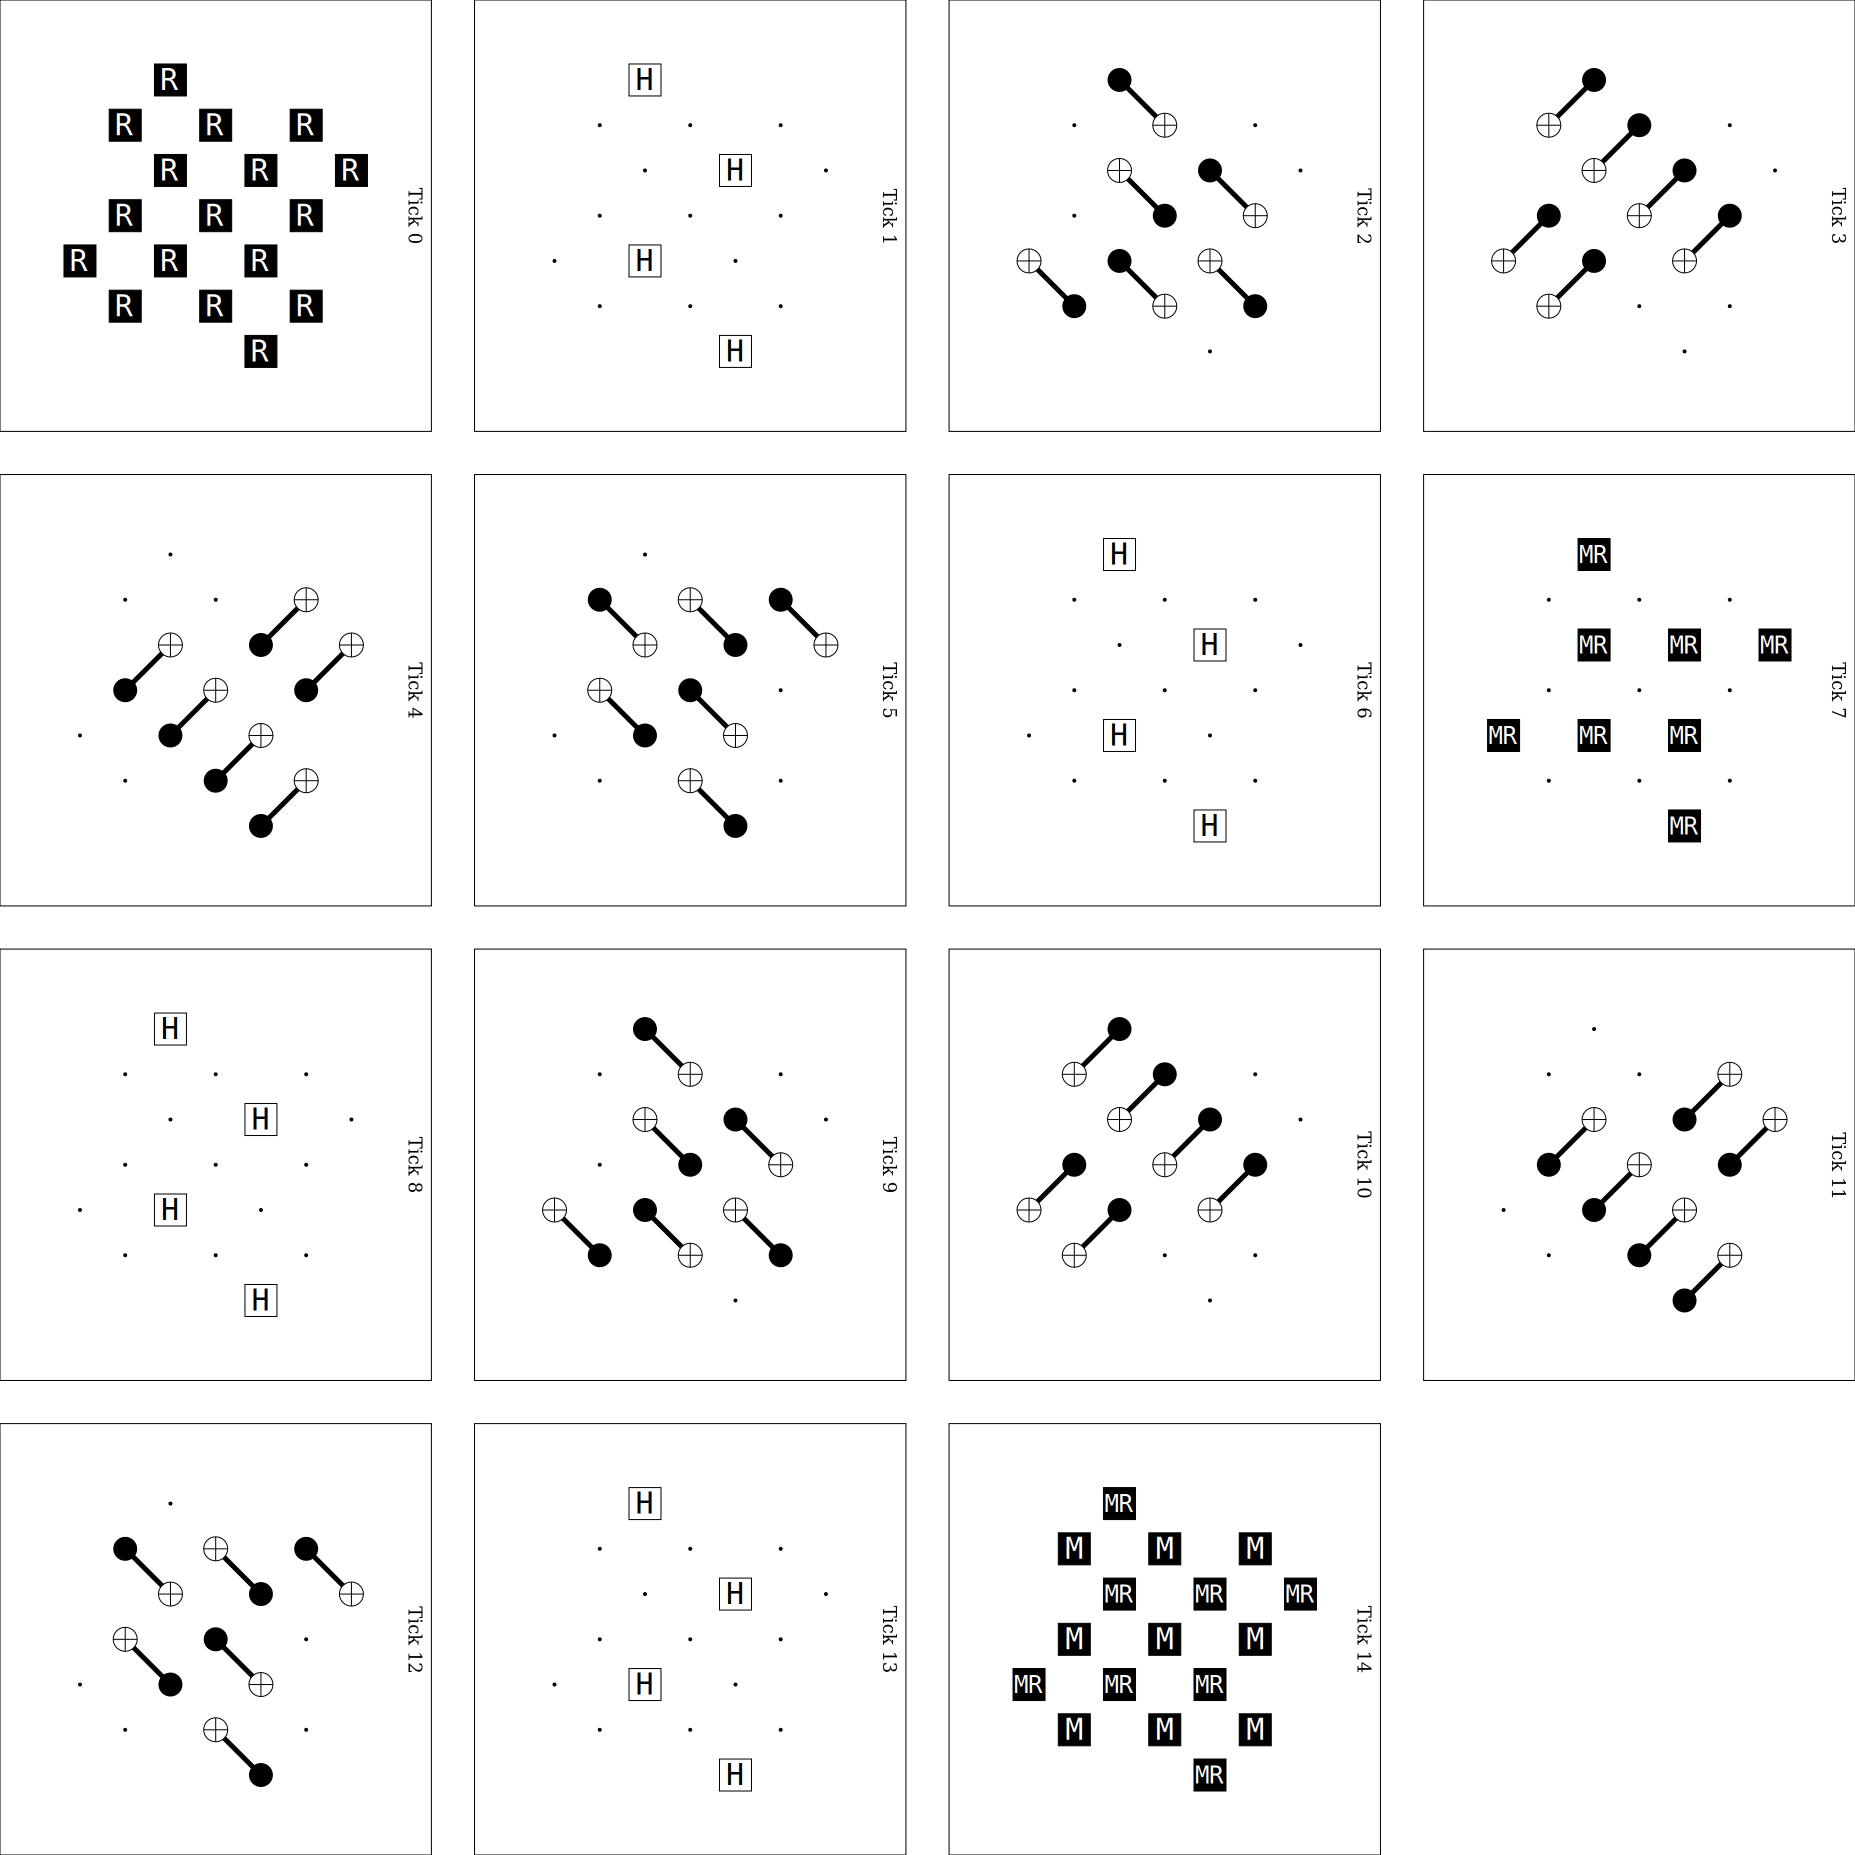

In [21]:


surface_code_circuit.without_noise().diagram("timeslice-svg")

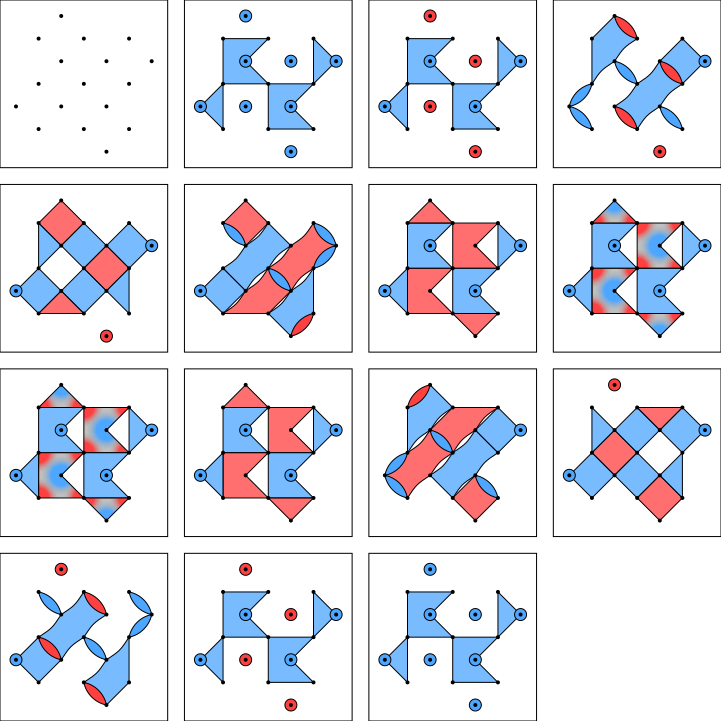

In [22]:
surface_code_circuit.diagram("detslice-svg")

接下来采样并收集数据。

In [48]:
import os

circuit = stim.Circuit.from_file('circuit_ideal_stim')
error_model = stim.DetectorErrorModel.from_file('error_model.dem')

task = sinter.Task(
    circuit=circuit,
    detector_error_model=error_model
)

surface_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_x",
            rounds=d * 3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d in [3, 5, 7, 9]
    for noise in [0.005, 0.007, 0.01, 0.0105, 0.011, 0.012, 0.013, 0.015, 0.017, 0.018, 0.019]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=os.cpu_count(),
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=True,
)

Starting 20 workers...
44 tasks left:
  workers    decoder eta shots_left errors_left json_metadata    
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.005  
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.007  
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.01   
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.0105 
        1 pymatching <1m     998703        4772 d=3,r=9,p=0.011  
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.012  
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.013  
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.015  
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.017  
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.018  
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.019  
        1 pymatching   ?    1000000        5000 d=5,r=15,p=0.005 
        1 pymatching   ?    1000000        5000 d=5,r=15,p=0.007 
        1 pymatching   ?    1000000   

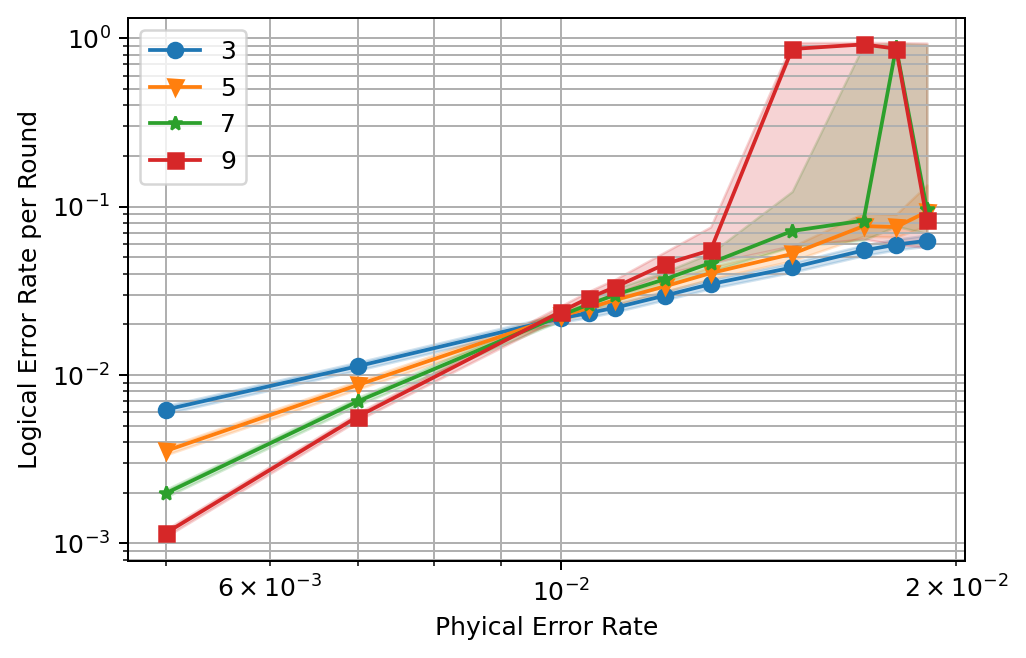

In [49]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)
# ax.set_ylim(5e-3, 5e-2)
# ax.set_xlim(0.008, 0.012)
ax.loglog()
# ax.set_title("Surface Code Error Rates per Round under Circuit Noise")

ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
ax.plot(markersize=3)

fig.set_dpi(180)  # Show it bigger


可见大致在 $p \approx 1.05\%$ 处为物理错误率阈值。

接下来尝试模拟在物理错误率不变的情况下，增加码距对逻辑错误率的影响。

In [39]:
noise = 1e-3

surface_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d * 3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d in [3, 5, 7, 9]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=os.cpu_count(),
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=5_000_000,
    max_errors=100,
    print_progress=True,
)


Starting 20 workers...
4 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        5 pymatching   ?    5000000         100 d=3,r=9,p=0.001 
        5 pymatching <1m    4998703         100 d=5,r=15,p=0.001
        5 pymatching   ?    5000000         100 d=7,r=21,p=0.001
        5 pymatching   ?    5000000         100 d=9,r=27,p=0.001
3 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        6 pymatching <1m    4951804          82 d=5,r=15,p=0.001
        7 pymatching <1m    4993037          99 d=7,r=21,p=0.001
        7 pymatching <1m    4998157         100 d=9,r=27,p=0.001
3 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        6 pymatching <1m    4859098          51 d=5,r=15,p=0.001
        7 pymatching <1m    4955081          98 d=7,r=21,p=0.001
        7 pymatching <1m    4988122         100 d=9,r=27,p=0.001
3 tasks left:
  workers    decoder        eta shots_left errors_left json_metadata   
    

KeyboardInterrupt: 

In [ ]:
import scipy.stats

# Compute the line fit.
xs = []
ys = []
log_ys = []
for stats in collected_surface_code_stats:
    d = stats.json_metadata['d']
    if not stats.errors:
        print(f"Didn't see any errors for d={d}")
        continue
    per_shot = stats.errors / stats.shots
    per_round = sinter.shot_error_rate_to_piece_error_rate(per_shot, pieces=stats.json_metadata['r'])
    xs.append(d)
    ys.append(per_round)
    print(f"logic error rate: {per_round}, code distance: {d}")
    log_ys.append(np.log(per_round))
fit = scipy.stats.linregress(xs, log_ys)
print(fit)

logic error rate: 0.00025129143081403793, code distance: 3
logic error rate: 2.6971209921067274e-05, code distance: 5
logic error rate: 2.6184594658085203e-06, code distance: 7
logic error rate: 2.5926100688522524e-07, code distance: 9
LinregressResult(slope=-1.148089190260184, intercept=-4.818463036156842, rvalue=-0.9999554914766864, pvalue=4.450852331361333e-05, stderr=0.007659699260782254, intercept_stderr=0.04904600598816133)


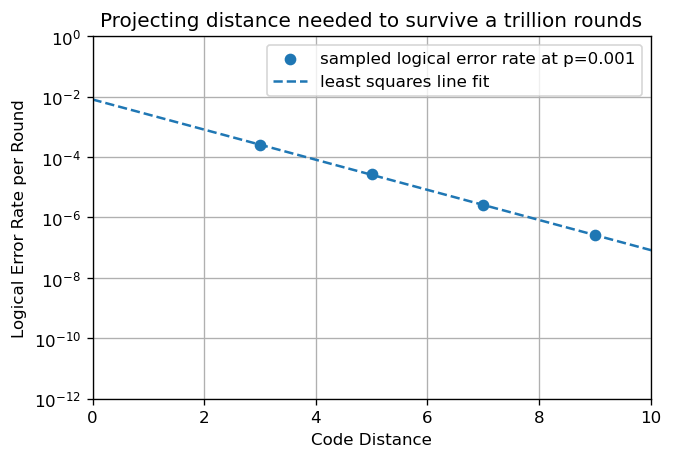

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.scatter(xs, ys, label=f"sampled logical error rate at p={noise}")
ax.plot([0, 25],
        [np.exp(fit.intercept), np.exp(fit.intercept + fit.slope * 25)],
        linestyle='--',
        label='least squares line fit')
ax.set_ylim(1e-12, 1e-0)
ax.set_xlim(0, 10)
ax.semilogy()
ax.set_title("Projecting distance needed to survive a trillion rounds")
ax.set_xlabel("Code Distance")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

_额外的内容详见_ _getting\_started.ipynb_。